In [1]:
# %pip install scikit-learn
# %pip install pandas 
# %pip install statsmodels
# %pip install xgboost
# %pip install rpy2
# %pip install shap
# %pip install matplotlib
# %pip install keras

In [2]:
from sklearn.ensemble import RandomForestRegressor
from shaprpy.datasets import load_california_housing

import pandas as pd
import xgboost as xgb
from statsmodels.datasets import get_rdataset
from shaprpy import explain
import shap as shap

/nr/samba/user/jbjornstad/shapr-venv/lib/python3.10/site-packages/rpy2/rinterface/__init__.py:1211: UserWarning: Environment variable "LD_LIBRARY_PATH" redefined by R and overriding existing variable. Current: "/nr/samba/user/jbjornstad/opt/R-4.4.2/lib:/nr/samba/user/jbjornstad/opt/R-4.4.2/lib/R/lib:/nr/samba/user/jbjornstad/opt/R-4.4.2/lib:/nr/samba/user/jbjornstad/opt/R-4.4.2/lib/R/lib:", R: "/nr/samba/user/jbjornstad/opt/R-4.4.2/lib:/usr/local/lib:/nr/samba/user/jbjornstad/opt/R-4.4.2/lib:/nr/samba/user/jbjornstad/opt/R-4.4.2/lib/R/lib:/nr/samba/user/jbjornstad/opt/R-4.4.2/lib:/nr/samba/user/jbjornstad/opt/R-4.4.2/lib/R/lib:"
  warnings.warn(
/nr/samba/user/jbjornstad/shapr-venv/lib/python3.10/site-packages/rpy2/rinterface/__init__.py:1211: UserWarning: Environment variable "PWD" redefined by R and overriding existing variable. Current: "/nr/samba/user/jbjornstad", R: "/nr/samba/user/jbjornstad/shapr/python"
  warnings.warn(
/nr/samba/user/jbjornstad/shapr-venv/lib/python3.10/site-p

In [3]:
def xgboost_model(x_train, y_train, from_file, filename=None): 
    if (from_file): 
        if ( not filename):
            filename = '../xgboost_model'
        model = xgb.Booster()
        model.load_model(filename)
        model.feature_names = x_train.columns.tolist()
    else: 
        model = xgb.XGBRegressor(n_estimators=20, verbosity=0)
        model.fit(x_train, y_train)
    return model

### Verifying against R results

In [4]:
airquality = get_rdataset("airquality", "datasets").data
data = airquality.dropna()

x_var = ["Solar.R", "Wind", "Temp", "Month"]
y_var = "Ozone"

x_train = data[x_var]
y_train = data[y_var]

In [5]:
model = xgboost_model(x_train=x_train, y_train=y_train, from_file=True)

In [6]:
explanation_SAGE = explain(
    model = model,
    x_train = x_train,
    x_explain = x_train,
    approach = 'independence',
    phi0 = y_train.mean().item(),
    seed=1,
    sage = True, 
    response = y_train, 
    verbose = None
)

print(explanation_SAGE["shapley_values_est"])

   explain_id         none    Solar.R        Wind        Temp     Month
1         NaN -1097.314474  146.53804  442.288023  498.620822  3.502053


In [7]:
explanation_SHAP = explain(   
    model = model,
    x_train = x_train,
    x_explain = x_train,
    approach = 'independence',
    phi0 = float(y_train.mean().item()),
    seed= 1,
    verbose = None
)

# print(explanation_SHAP["shapley_values_est"])

### Test plotting

In [8]:
from shaprpy.plot import plot

In [9]:
from shap import plots, Explanation

In [10]:
explanation_SAGE["shapley_values_est"].shape

(1, 6)

In [11]:
explanation_SHAP["shapley_values_est"].shape

(111, 6)

In [12]:
shap_values_df = explanation_SHAP['shapley_values_est']
feature_names = shap_values_df.columns.drop(['explain_id', 'none'])

shap_vals = shap_values_df[feature_names].values
base_values = shap_values_df["none"].values
data = shap_values_df[feature_names].values

explanation = Explanation(
    values=shap_vals,
    base_values=base_values,
    data=data,
    feature_names=feature_names.tolist()
)

In [22]:
len(range(1,10))

9

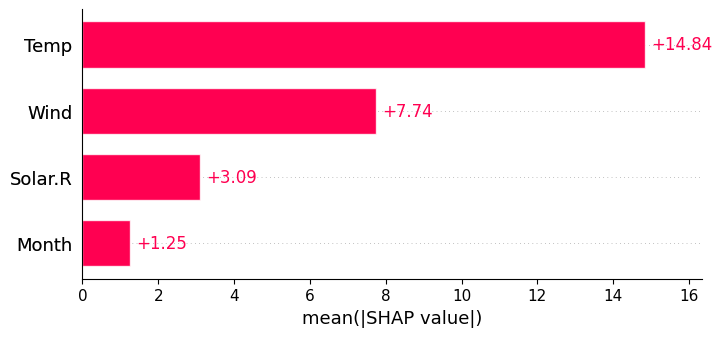

In [30]:
plots.bar(explanation[slice(10)]) 

In [ ]:
plot(explanation_SHAP, indexing=slice(10), plot_mean = False)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (3139962689.py, line 1)